<a href="https://colab.research.google.com/github/maltevolle/PMML-Project/blob/main/Project_PMML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
# Load the data
(train_data, validation_data, test_data), info = tfds.load('cats_vs_dogs',
                                                           split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                           with_info=True,
                                                           as_supervised=True)

# Get the label names
label_names = info.features['label'].names

# Preprocessing function: resize and normalize images
def preprocess_image(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

# Apply preprocessing and batch the data
batch_size = 32
train_data = train_data.map(preprocess_image).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_data = validation_data.map(preprocess_image).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_image).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Display some sample images
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_data.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(label_names[label.numpy()])
    plt.axis('off')
plt.show()


Der Code missklassifiziert die bilder von cats vs dogs mit imagenet. Ich weiß nicht so ganz was der macht aber es funktioniert :)

Verarbeite Testdaten...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Original prediction: ('n02123597', 'Siamese_cat', 0.99971825)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
Adversarial prediction: ('n02108089', 'boxer', 0.9999889)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Original prediction: ('n02123045', 'tabby', 0.6500568)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
Adversarial prediction: ('n02108089', 'boxer', 1.0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Original prediction: ('n02124075', 'Egyptian_cat', 0.5071673)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Adversarial prediction: ('n02480495', 'orangutan', 0.18125695)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Original prediction: ('n02110185', 'Siberian_husky', 0.15314753)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
Adversarial prediction: ('n02123045', 'tabby', 0.9997203)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Original prediction: ('n02086240', 'Shih-Tzu', 0.8489927)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
Adversarial prediction: ('n02123045', 'tabby', 0.9999894

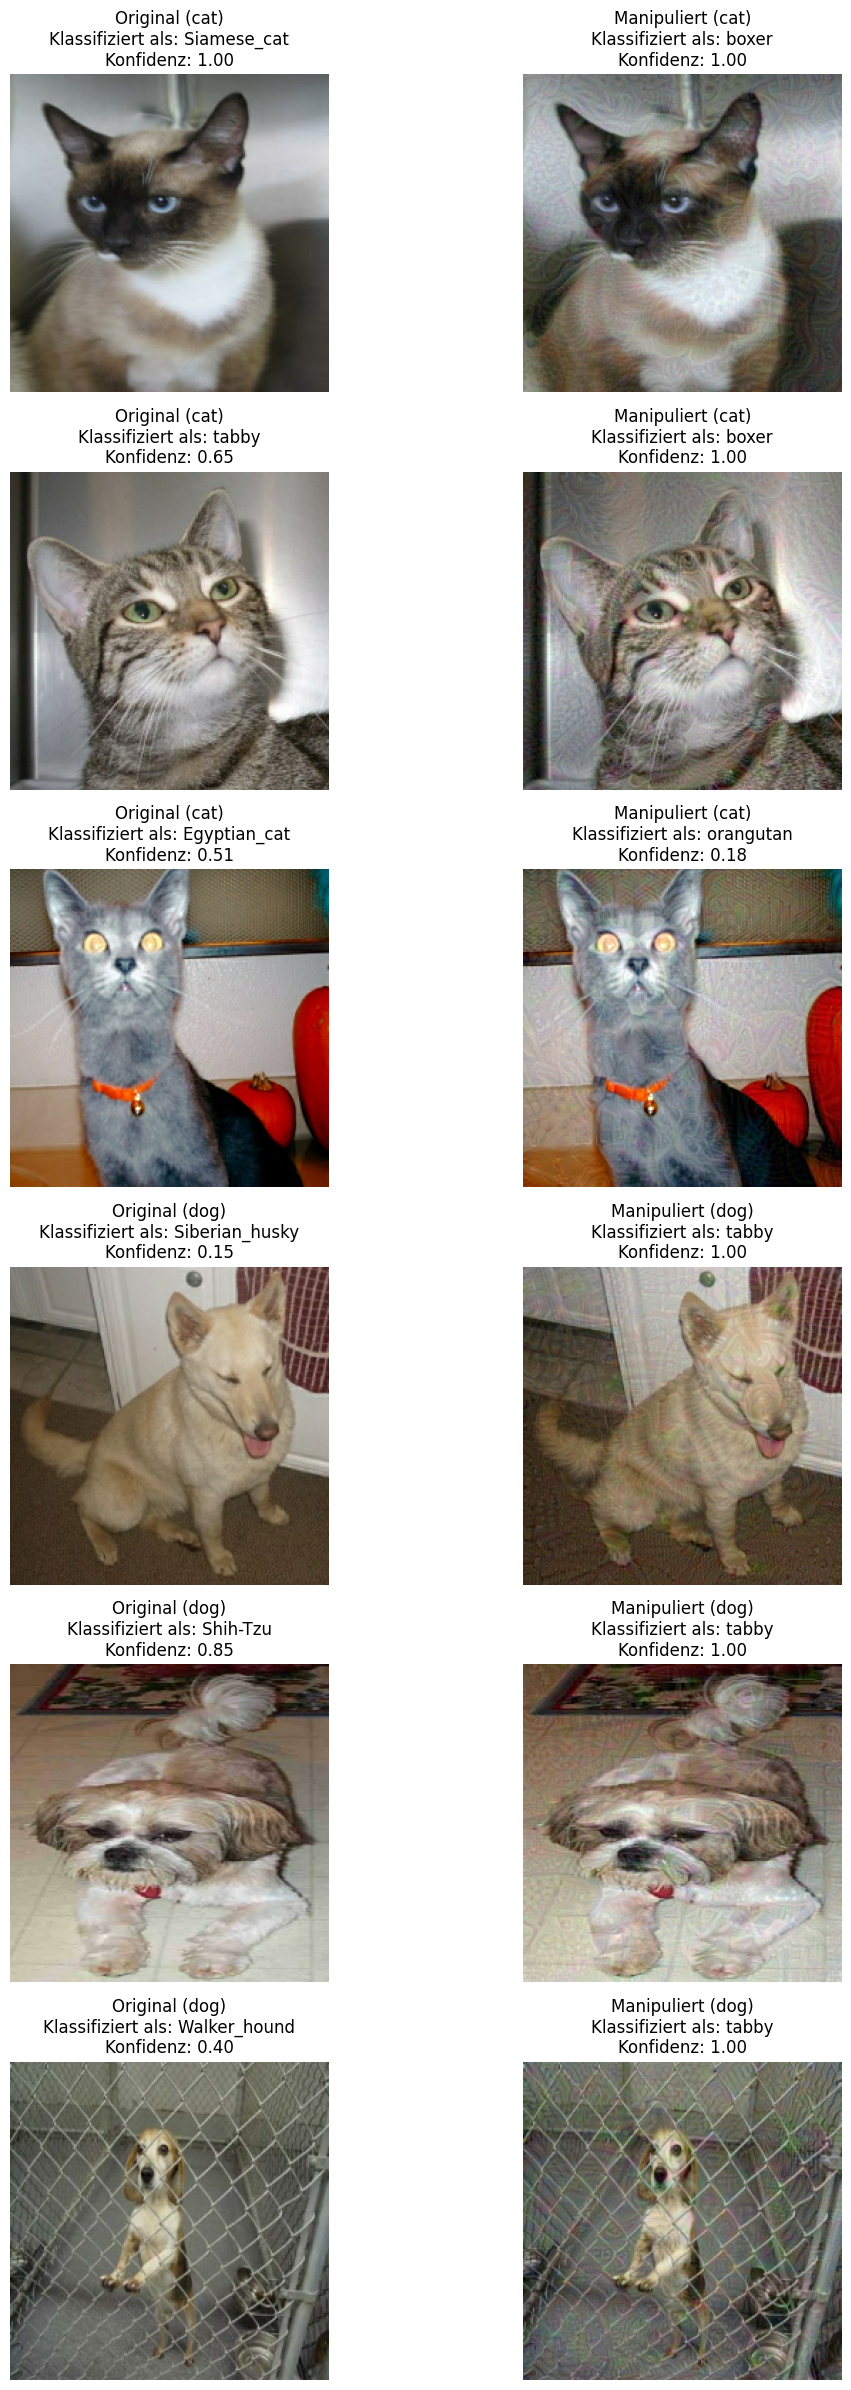

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import random

# Laden des vortrainierten Modells
model = VGG16(weights='imagenet')

def load_dataset():
    """Lädt das Cats vs Dogs Dataset von TensorFlow Datasets"""
    dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)
    train_ds, validation_ds, test_ds = tfds.load(
        'cats_vs_dogs',
        split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'],
        as_supervised=True
    )
    return train_ds, validation_ds, test_ds

def prepare_image(image, label):
    """Bereitet ein einzelnes Bild für VGG16 vor"""
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.expand_dims(image, 0)
    return image, label

def create_adversarial_image(image, target_class, epsilon=20.0, iterations=10):
    """Erstellt ein adversariales Beispiel mit iterativem Angriff"""
    image_tensor = tf.convert_to_tensor(image)
    adv_image = tf.identity(image_tensor)

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            # Vorverarbeitung für VGG16
            processed_image = preprocess_input(adv_image)
            prediction = model(processed_image)
            loss = -tf.keras.losses.SparseCategoricalCrossentropy()(
                tf.constant([target_class]), prediction
            )

        # Gradient berechnen und anwenden
        gradient = tape.gradient(loss, adv_image)
        normalized_gradient = tf.sign(gradient)
        adv_image = adv_image + epsilon * normalized_gradient / iterations

        # Clip um sicherzustellen, dass wir im gültigen Bildbereich bleiben
        adv_image = tf.clip_by_value(adv_image, 0, 255)

    return adv_image

def predict_class(image_array):
    """Vorhersage der Klasse mit VGG16"""
    processed_image = preprocess_input(tf.cast(image_array, tf.float32))
    predictions = model.predict(processed_image)
    decoded_predictions = tf.keras.applications.vgg16.decode_predictions(predictions, top=3)[0]
    return decoded_predictions[0]

def process_dataset_samples(dataset, num_samples=3):
    """Verarbeitet Beispiele aus dem Dataset"""
    results = []

    # Sammle Beispiele für beide Klassen
    cat_samples = []
    dog_samples = []

    for image, label in dataset:
        if len(cat_samples) < num_samples and label == 0:  # Katze
            cat_samples.append((image, label))
        elif len(dog_samples) < num_samples and label == 1:  # Hund
            dog_samples.append((image, label))

        if len(cat_samples) >= num_samples and len(dog_samples) >= num_samples:
            break

    # Verarbeite alle Samples
    for image, label in cat_samples + dog_samples:
        # Bild vorbereiten
        original_img, _ = prepare_image(image, label)

        # Original klassifizieren
        original_pred = predict_class(original_img)
        print(f"Original prediction: {original_pred}")

        # Target-Klasse festlegen (281 für Katze, 242 für Hund in VGG16)
        target_class = 242 if label == 0 else 281  # 0 = Katze, 1 = Hund

        # Adversariales Beispiel erstellen
        adversarial_img = create_adversarial_image(original_img, target_class,
                                                 epsilon=20.0, iterations=10)
        adversarial_pred = predict_class(adversarial_img)
        print(f"Adversarial prediction: {adversarial_pred}")

        results.append({
            'original_img': original_img,
            'adversarial_img': adversarial_img,
            'original_pred': original_pred,
            'adversarial_pred': adversarial_pred,
            'true_class': 'cat' if label == 0 else 'dog'
        })

    return results

def plot_results(results):
    """Visualisiert die Ergebnisse"""
    n = len(results)
    fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))

    if n == 1:
        axes = axes.reshape(1, -1)

    for i, result in enumerate(results):
        # Original Bild
        orig_img = tf.cast(result['original_img'][0], tf.uint8).numpy()
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f'Original ({result["true_class"]})\n'
                            f'Klassifiziert als: {result["original_pred"][1]}\n'
                            f'Konfidenz: {result["original_pred"][2]:.2f}')

        # Adversariales Bild
        adv_img = tf.cast(result['adversarial_img'][0], tf.uint8).numpy()
        axes[i, 1].imshow(adv_img)
        axes[i, 1].set_title(f'Manipuliert ({result["true_class"]})\n'
                            f'Klassifiziert als: {result["adversarial_pred"][1]}\n'
                            f'Konfidenz: {result["adversarial_pred"][2]:.2f}')

        # Achsenbeschriftungen entfernen
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Hauptprogramm
if __name__ == "__main__":
    # Dataset laden
    train_ds, validation_ds, test_ds = load_dataset()

    print("Verarbeite Testdaten...")
    # Verwende Testdaten für die Demonstration
    results = process_dataset_samples(test_ds, num_samples=3)

    print("Zeige Ergebnisse...")
    plot_results(results)